<a href="https://colab.research.google.com/github/tyoamazinglib/recommender-system-tfrs/blob/master/fedrecsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Federated Dependency

In [1]:
# Installing TensorFlow Federated
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade tensorflow
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 819 kB 5.2 MB/s 
     |████████████████████████████████| 238 kB 51.2 MB/s 
     |████████████████████████████████| 251 kB 51.1 MB/s 
     |████████████████████████████████| 126 kB 13.8 MB/s 
     |████████████████████████████████| 4.0 MB 35.6 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
     |████████████████████████████████| 65.2 MB 121 kB/s 
     |████████████████████████████████| 120 kB 50.8 MB/s 
     |████████████████████████████████| 498.0 MB 9.2 kB/s 
     |████████████████████████████████| 887 kB 31.6 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 1.4 MB 52.8 MB/s 
     |████████████████████████████████| 5.8 MB 52.8 MB/s 
     |████████████████████████████████| 462 kB 66.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.4 requi

In [2]:
# Import other stuff
import collections
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(42)

# Dataset preparation

In [4]:
# Datasets download and preparation
PATH = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "/tmp"

# Fetch dataset from grouplens
r = requests.get(PATH)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=DATA_DIR)

# Loads up the dataset using pandas
ratings_df = pd.read_csv(os.path.join(DATA_DIR, "ml-1m", "ratings.dat"), 
                         sep='::', 
                         names=["UserID", "MovieID", "Rating", "Timestamp"],
                         engine="python",
                         encoding='latin-1')

movies_df = pd.read_csv(os.path.join(DATA_DIR, "ml-1m", "movies.dat"), 
                         sep='::', 
                         names=["MovieID", "Title", "Genres"],
                         engine="python",
                         encoding='latin-1')

# Mapping dictionary in a new index
movie_mapping = {old_movie: new_movie for new_movie, old_movie in enumerate(ratings_df.MovieID.astype("category").cat.categories)}
user_mapping = {old_user: new_user for new_user, old_user in enumerate(ratings_df.UserID.astype("category").cat.categories)}

# Map each DataFrame consistently using the now-fixed mapping.
ratings_df.MovieID = ratings_df.MovieID.map(movie_mapping)
ratings_df.UserID = ratings_df.UserID.map(user_mapping)
movies_df.MovieID = movies_df.MovieID.map(movie_mapping)

# Remove nulls result from movies_df
movies_df = movies_df[pd.notnull(movies_df.MovieID)]

In [6]:
# Sanity check of number of users and movies
print('Num users:', len(set(ratings_df.UserID)))
print('Num movies:', len(set(ratings_df.MovieID)))

Num users: 6040
Num movies: 3706


# Preprocessing Datasets

In [9]:
# Helper function to create dataset based on user list
def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  num_users = len(set(ratings_df.UserID))
  # Optionally limit to `max_clients` to speed up data loading.
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    # Each example looks like: {x: movie_id, y: rating}.
    # We won't need the UserID since each client will only look at their own
    # data.
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])

  tf_datasets = []
  for user in range(num_users):
    # Get subset of ratings_df belonging to a particular user.
    user_ratings_df = ratings_df[ratings_df.UserID == user]

    tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)

    # Define preprocessing operations.
    tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
        buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    tf_datasets.append(tf_dataset)

  return tf_datasets

def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_idx = int(len(tf_datasets) * train_fraction)
  val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

  # Note that the val and test data contains completely different users, not
  # just unseen ratings from train users.
  return (tf_datasets[:train_idx], tf_datasets[train_idx:val_idx],
          tf_datasets[val_idx:])

In [10]:
# We limit the number of clients to speed up dataset creation. Feel free to pass
# max_clients=None to load all clients' data.
tf_datasets = create_tf_datasets(
    ratings_df=ratings_df,
    batch_size=5,
    max_examples_per_user=300,
    max_clients=2000)

# Split the ratings into training/val/test by client.
tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
    val_fraction=0.1)

# Defining Federated Model

In [11]:
# Define a single Keras layer representing an embedding for a single user
class UserEmbedding(tf.keras.layers.Layer):
  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)

In [13]:
def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int) -> tff.learning.reconstruction.Model:
  """Defines a Keras matrix factorization model."""
  # Layers with variables will be partitioned into global and local layers.
  # We'll pass this to `tff.learning.reconstruction.from_keras_model`.
  global_layers = []
  local_layers = []

  # Extract the item embedding.
  # This will be the global layers and the layers stored on the centralized setting
  item_input = tf.keras.layers.Input(shape=[1], name='Item')
  item_embedding_layer = tf.keras.layers.Embedding(
      num_items,
      num_latent_factors,
      name='ItemEmbedding')
  global_layers.append(item_embedding_layer)
  flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
      item_embedding_layer(item_input))

  # Extract the user embedding.
  # This will be the local layers and the layers stored on each clients setting
  user_embedding_layer = UserEmbedding(
      num_latent_factors,
      name='UserEmbedding')
  local_layers.append(user_embedding_layer)

  # The item_input never gets used by the user embedding layer,
  # but this allows the model to directly use the user embedding.
  flat_user_vec = user_embedding_layer(item_input)

  # Compute the dot product between the user embedding, and the item one.
  pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])

  input_spec = collections.OrderedDict(
      x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
      y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

  model = tf.keras.Model(inputs=item_input, outputs=pred)

  return tff.learning.reconstruction.from_keras_model(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)

# This will be used to produce our training process.
# User and item embeddings will be 50-dimensional.
embedding_dimension = 50

model_fn = functools.partial(
    get_matrix_factorization_model,
    num_items=len(set(ratings_df.MovieID)),
    num_latent_factors=embedding_dimension)

In [15]:
# Defining loss and metrics
class RatingAccuracy(tf.keras.metrics.Mean):
  """Keras metric computing accuracy of reconstructed ratings."""

  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    # A [batch_size, 1] tf.bool tensor indicating correctness within the
    # threshold for each example in a batch. A 0.5 threshold corresponds
    # to correctness when predictions are rounded to the nearest whole
    # number.
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)


loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy()]

# Training Federated Reconstruction

In [16]:
# Federated Training Process
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.Adagrad(learning_rate=1),
    client_optimizer_fn=lambda: tf.keras.optimizers.Adagrad(learning_rate=0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Federated Evaluation Process
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.Adagrad(learning_rate=0.1))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
# Initialize Model State
# This model has yet to be trained so its states are randomly initialized
state = training_process.initialize()
print(state.model)
print('Item variables shape:', state.model.trainable[0].shape)

ModelWeights(trainable=[array([[ 0.00736888,  0.02336642, -0.04540435, ..., -0.02964649,
         0.01241489,  0.02297821],
       [-0.00729835,  0.0409385 ,  0.03414372, ...,  0.04860852,
         0.01309707,  0.01051408],
       [ 0.01503105,  0.04270992, -0.02810532, ..., -0.04550613,
         0.02217412, -0.03384804],
       ...,
       [ 0.04828994,  0.00433628,  0.03431237, ...,  0.03667572,
        -0.00148537, -0.03072908],
       [ 0.01552198,  0.03013653,  0.04520733, ...,  0.02823322,
         0.04837615,  0.00344805],
       [-0.01403578, -0.03861239,  0.00376076, ..., -0.00570349,
        -0.00883814, -0.01722107]], dtype=float32)], non_trainable=[])
Item variables shape: (3706, 50)


In [18]:
# Testing evaluation pipelines on evaluating initial state model
eval_metrics = evaluation_computation(state.model, tf_val_datasets)
print('Initial Eval:', eval_metrics['eval'])

Initial Eval: OrderedDict([('loss', 14.308943), ('rating_accuracy', 0.0)])


In [20]:
# Training loops
NUM_EPOCHS = 20
NUM_CLIENT_PER_EPOCH = 50

train_losses = []
train_accs = []

# This may take a couple minutes to run.
print(f"Training with {NUM_CLIENT_PER_EPOCH} clients per sample of Epoch. Total number of epochs: {NUM_EPOCHS}")
for i in range(NUM_EPOCHS):
  federated_train_data = np.random.choice(tf_train_datasets, size=NUM_CLIENT_PER_EPOCH, replace=False).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Epoch {i+1}/{NUM_EPOCHS}:', metrics['train'])
  train_losses.append(metrics['train']['loss'])
  train_accs.append(metrics['train']['rating_accuracy'])


eval_metrics = evaluation_computation(state.model, tf_val_datasets)
print('Final Eval:', eval_metrics['eval'])

Training with 50 clients per sample of Epoch. Total number of epochs: 20
Epoch 1/20: OrderedDict([('rating_accuracy', 0.12321982), ('loss', 5.95558)])
Epoch 2/20: OrderedDict([('rating_accuracy', 0.18577375), ('loss', 4.469394)])
Epoch 3/20: OrderedDict([('rating_accuracy', 0.22930153), ('loss', 3.1820974)])
Epoch 4/20: OrderedDict([('rating_accuracy', 0.234748), ('loss', 3.1714163)])
Epoch 5/20: OrderedDict([('rating_accuracy', 0.28282207), ('loss', 2.173332)])
Epoch 6/20: OrderedDict([('rating_accuracy', 0.26263002), ('loss', 2.4687662)])
Epoch 7/20: OrderedDict([('rating_accuracy', 0.29835212), ('loss', 2.1852582)])
Epoch 8/20: OrderedDict([('rating_accuracy', 0.31662804), ('loss', 1.9667714)])
Epoch 9/20: OrderedDict([('rating_accuracy', 0.29695252), ('loss', 2.0842395)])
Epoch 10/20: OrderedDict([('rating_accuracy', 0.30732948), ('loss', 1.8183647)])
Epoch 11/20: OrderedDict([('rating_accuracy', 0.29972085), ('loss', 1.8831412)])
Epoch 12/20: OrderedDict([('rating_accuracy', 0.345

# Model Evaluation

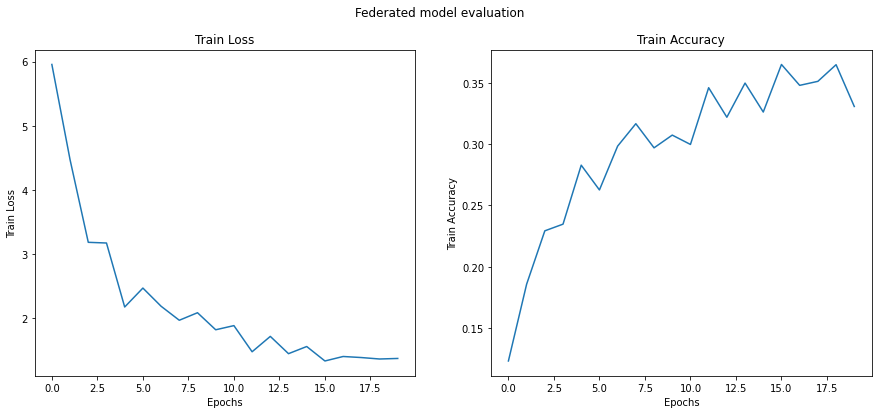

In [24]:
# Evaluating model
fig, ax = plt.subplots(1, 2)
fig.suptitle('Federated model evaluation')
fig.set_size_inches(15, 6)

ax[0].plot(range(NUM_EPOCHS), train_losses)
ax[0].set_ylabel('Train Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train Loss')

ax[1].plot(range(NUM_EPOCHS), train_accs)
ax[1].set_ylabel('Train Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Train Accuracy')

plt.show()